# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the Data

In this first code block, we will explore the dataset by examining its dimensionality and distribution. The training set is made up of **25,500 samples**, each with **24 attributes** that capture a wide array of data points relevant to the problem. This dimensionality provides a thorough representation of the features. Looking at the output, we find that there are **2 unique target classes**, indicating a binary classification problem. The label distribution reveals a notable class imbalance: **19,815 samples** belong to class **0**, while only **5,685 samples** are in class **1**. Recognizing this disparity is extremely important, as it can impact model performance, particularly regarding accuracy and recall metrics. To address such imbalances, techniques that consider the uneven distribution of classes may be required.

The dataset has no missing values across all features, so data absence will not hinder our analysis. This preliminary analysis also indicates that the numerical features vary significantly. For instance, the `LIMIT_BAL` feature ranges from **10,000 to 1,000,000**, while `PAY_AMT1` ranges from **0 to 1,684,259**. This variation suggests the need for normalization or standardization during preprocessing to prevent any single feature from disproportionately influencing the model due to its scale.

Examining the first few samples of the training set provides insights into the data's underlying structure. For example, some features contain negative values, particularly the payment history features. Understanding the implications of these values is important for interpreting the dataset and training the model effectively. These features may indicate insolvencies, which are important for predicting defaults.

In [24]:
# Import necessary libraries
import pandas as pd  
import numpy as np  
import os 

# Set environment variable to suppress TensorFlow logging warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    """
    Load and preprocess data from a specified CSV file.

    Parameters:
    path (str): The path to the CSV file to be loaded.
    train (bool): A flag indicating whether to load training data or test data.
                  If True, the data will be shuffled and returned without the last column (target variable).
                  If False, the first column will be treated as labels, and the rest as features.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing:
        - A NumPy array of features.
        - A NumPy array of labels (if train is True) or a NumPy array of IDs (if train is False).
    """
    # Load data from the specified CSV file with the given encoding
    df = pd.read_csv(path, encoding="ISO-8859-2")

    if train:
        # Shuffle the data and return features and labels for training
        data = df.sample(frac=1, random_state=42).values
        return data[:, :-1].astype(np.float32), data[:, -1]

    # Return features and IDs for test data
    return df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)

# Load training and testing data
X_train, labels = load_data('./train.csv')  # Load training data
X_test, ids = load_data('./test.csv', train=False)  # Load test data

# Display the dimensions of the training set and the count of features
print(f"\nTraining set dimensions: {X_train.shape}\nFeatures count: {X_train.shape[1]}")

# Count the number of unique classes in the labels
num_classes = len(np.unique(labels))
print(f"Number of target classes: {num_classes}")

# Display the first five samples of the training set
print("\nFirst 5 training samples:\n", pd.DataFrame(X_train).head())

# Display the distribution of the labels in the training set
print("\nLabels distribution:\n", pd.Series(labels).value_counts())

# Load the training data again for analysis
train_data = pd.read_csv('./train.csv')

# Display the count of missing values for each column in the training data
print("\nMissing values:\n", train_data.isnull().sum())

# Display summary statistics for the training data
print("\nSummary statistics:\n", train_data.describe())

# Display the dimensions of the test set
print("\nTest set dimensions:", X_test.shape)

# Display the actual training set data and corresponding labels
print("\nTraining set data:\n", X_train)
print("\nTraining set labels:\n", labels)


Training set dimensions: (25500, 24)
Features count: 24
Number of target classes: 2

First 5 training samples:
         0         1    2    3    4     5    6    7    8    9   ...       14  \
0  21870.0   70000.0  2.0  3.0  2.0  26.0  0.0  0.0  0.0  0.0  ...   8948.0   
1  15211.0  320000.0  2.0  2.0  2.0  28.0 -1.0 -1.0 -1.0 -1.0  ...    944.0   
2  20041.0   30000.0  2.0  2.0  2.0  36.0  0.0 -1.0 -1.0  0.0  ...  30452.0   
3   9190.0   20000.0  2.0  3.0  1.0  35.0  0.0  0.0  2.0  2.0  ...  18621.0   
4   6260.0   80000.0  1.0  2.0  2.0  32.0  1.0  2.0  0.0  0.0  ...  28242.0   

        15       16       17      18       19      20      21      22      23  
0   9006.0  10570.0  11421.0  2000.0   1200.0  1500.0  2000.0  1000.0  2000.0  
1    473.0   1747.0   1193.0   390.0    944.0   473.0  5000.0  1200.0   980.0  
2  29667.0  28596.0  29180.0   490.0  33299.0  1400.0   572.0   584.0   400.0  
3  18024.0  18434.0  19826.0  3000.0   1000.0     0.0   700.0  1700.0     0.0  
4  21400.0  

## Preparing the Data

In this second code cell, we detail the pre-processing steps taken to prepare the dataset for model training. Based on insights gained from the initial data inspection, several decisions were made to ensure an effective analysis. The first step was to extract the relevant features and labels from the raw training dataset. We isolated the label column, `default payment next month`, for use in model training. The `ID` column was deemed unnecessary for predictive modeling, as it does not contribute in understanding the features that influence the outcome. As a consequence, it was dropped from the feature matrix to streamline the dataset. Next, we needed to address the varying scales of the features. The variance plot revealed that some features had significantly higher variances than others. This could skew the model's performance, as features with larger scales might dominate the learning process. To counter this, **StandardScaler** was used, which standardizes features by removing the mean and scaling to unit variance. This process ensures that each feature contributes equally to the analysis.
 
The dataset was then split into training and validation sets using a stratified approach. This method preserves the original class distribution in both subsets, which is especially important due to the class imbalance identified earlier. The training set consists of **15,300 samples**, while the validation set includes **10,200 samples**. This balanced strategy minimizes the risk of overfitting and improves the reliability of model evaluation. After the data split, we applied **StandardScaler** to the training set, generating scaled feature values. The same scaler was applied to the validation set to ensure consistency in data transformation. This step is important for maintaining the same data distribution during both training and validation phases, thus enhancing the generalization of learned patterns.


In [25]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 

def preprocess_data(X, scaler=None):
    """
    Preprocesses the input data by scaling the features using StandardScaler.
    
    Parameters:
    X (pd.DataFrame or np.array): Feature data to be scaled.
    scaler (StandardScaler, optional): Pre-fitted scaler object. If None, a new scaler will be fitted to the data.
    
    Returns:
    tuple:
        - Scaled feature matrix (np.array)
        - Fitted scaler (StandardScaler object)
    
    The function either uses an existing scaler to transform the data or fits a new one if none is provided.
    """
    # If no scaler is provided, fit a new StandardScaler to the data
    if scaler is None:
        scaler = StandardScaler().fit(X)
    
    # Transform the data using the fitted scaler
    return scaler.transform(X), scaler

# Load the training dataset
df_train = pd.read_csv('./train.csv')

# Extract the label column ('default payment next month') from the dataset
labels_raw = df_train['default payment next month']

# Specify columns to be dropped from the feature matrix (e.g., 'ID' and the label column)
columns_to_drop = ["ID"]

# Drop the specified columns and the label from the training dataset to create the feature matrix
X_train_raw = df_train.drop(columns=columns_to_drop + ['default payment next month'])

# Split the dataset into training and validation sets (60% train, 40% validation)
# Stratify ensures that the class distribution is maintained in both train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, 
                                                  test_size=0.4, random_state=42, stratify=labels_raw)

# Scale the training data using StandardScaler
X_train_scaled, scaler = preprocess_data(X_train)

# Use the same scaler to scale the validation data
X_val_scaled, _ = preprocess_data(X_val, scaler)

# Output the shapes of the scaled training and validation datasets as well as their corresponding label sets
print(f"Shapes -> Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, "
      f"Encoded Train: {y_train.shape}, Encoded Val: {y_val.shape}")

Shapes -> Train: (15300, 23), Val: (10200, 23), Encoded Train: (15300,), Encoded Val: (10200,)


## Building the Network

In this third code cell, the procedure followed in choosing the network structure and hyperparameters will be described. Please note that to arrive at the following network, a lot of trial and error was necessary. While some high-level decisions, such as the choice of the sigmoid function for the output layer, are clear and almost mandatory, other choices—like the implementation of batch normalization and the selection of regularization parameters—were guided more by empirical observations than by any established principles.

### Network Structure

1. **Input Layer**: the model begins with an input layer that corresponds to the number of features in the dataset, totaling `23` after preprocessing.

2. **Hidden Layers**:
   - **Layer Configuration**: three hidden layers were used, with sizes decreasing from `256` to `128` and then to `64` neurons. This structure supports a hierarchical approach to feature extraction, enabling the model to learn progressively abstract representations of the data.
   - **Activation Function**: all hidden layers employ the `ReLU` activation function. This choice facilitates faster convergence during training and mitigates the vanishing gradient problem often encountered with `sigmoid` or `tanh` functions.
   - **Regularization**: each hidden layer includes L2 regularization (`kernel_regularizer=l2(0.01)`) to reduce overfitting by penalizing large weights.
   - **Batch Normalization**: `Batch Normalization` was implemented after each layer to stabilize learning by normalizing the outputs of the previous layer. This adjustment enables higher learning rates and accelerates convergence.
   - **Dropout Layers**: dropout layers were added, with rates of `0.3` for the first two layers and `0.2` for the last. This strategy prevents overfitting by randomly dropping a portion of neurons during training.

3. **Output Layer**: the output layer consists of a single neuron with a `sigmoid` activation function, which aligns with the binary nature of the classification task. 

### Hyperparameters

1. **Optimizer**: the `Adam` optimizer was selected, using a learning rate of `0.0005`. Adam is beneficial due to its adaptive learning rate properties, which promote faster convergence and training stability.

2. **Loss Function**: the chosen loss function is `binary cross-entropy`, which is suitable for binary classification tasks. It assesses model performance by comparing predicted and actual labels.

3. **Batch Size**: a batch size of `128` was used, providing stable gradient estimates and smoothing updates during training.

4. **Epochs**: a maximum of `70` epochs was set, implementing early stopping to avert overfitting. Early stopping monitors validation loss and stops training if there’s no improvement for 15 consecutive epochs _(patience)_.

5. **Learning Rate Adjustment**: the learning rate is adjusted dynamically using the `ReduceLROnPlateau` callback, which reduces the learning rate by a factor of `0.2` if the validation loss does not improve for `10` epochs. This helps fine-tune the learning process during training. The reason why this adjustment was added is because, empirically, it led to better results on the dataset at hand

### Training and Evaluation

- The model was trained with the shuffle option enabled, ensuring a randomized order of training samples for each epoch. This helps enhance generalization.
- After training, the model was evaluated on the validation set, yielding a validation loss between **0.44** and **0.50**, an accuracy ranging from **0.81 to 0.83**, and an F1 score that falls between **0.45** and **0.50**. At the time of writing, the highest accuracy value recorded was **0.8316**. The model was saved locally for future reference. These variations arise from the random initialization of weights in neural networks, leading to differences in results across training sessions.

In [36]:
# Import necessary libraries for building the model and evaluation
from keras.optimizers import Adam  # Adam optimizer for gradient descent
from keras.layers import Dense, BatchNormalization, Dropout  # Layers for the neural network
from keras.models import Sequential  # Sequential model type
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback  # Callbacks for training
from sklearn.metrics import f1_score  # F1 score for performance evaluation
from keras.layers import Input  # Input layer for defining the model input shape
from keras.regularizers import l2  # L2 regularization to prevent overfitting

def build_model(input_shape):
    """
    Builds a sequential neural network model with the specified input shape.

    Parameters:
    input_shape (int): The number of features in the input data.

    Returns:
    keras.models.Sequential: Compiled Keras model ready for training.
    """
    model = Sequential()  # Initialize the sequential model
    
    # Input layer definition
    model.add(Input(shape=(input_shape,)))
    
    # First hidden layer with 256 neurons, ReLU activation, and L2 regularization
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(momentum=0.9))  # Normalize outputs to stabilize learning
    model.add(Dropout(0.3))  # Dropout layer to reduce overfitting
    
    # Second hidden layer with 128 neurons, ReLU activation, and L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(momentum=0.9))  # Normalize outputs
    model.add(Dropout(0.3))  # Dropout layer
    
    # Third hidden layer with 64 neurons, ReLU activation, and L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(momentum=0.9))  # Normalize outputs
    model.add(Dropout(0.2))  # Lower dropout rate in the final layers to retain more information
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary output
    
    # Configure the Adam optimizer
    optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
    
    # Compile the model with the specified loss function and metrics
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Determine input shape based on the training data
input_shape = X_train_scaled.shape[1]
model = build_model(input_shape)  # Build the model

# Set training parameters
batch_size = 128  # Number of samples per gradient update
epochs = 70       # Total number of epochs to train the model

# Display the model summary to understand the architecture
model.summary()

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,  # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore model weights from the best epoch
    min_delta=0.001  # Minimum change to qualify as an improvement
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=10,  # Number of epochs to wait before reducing the learning rate
    min_lr=1e-6,  # Minimum learning rate
    min_delta=0.001  # Minimum change to qualify as an improvement
)

# Output the input shape for clarity
dims = X_train_scaled.shape[1]
print('Input Shape: ', dims)

# Determine the number of output classes
nb_classes = y_train.shape[1] if len(y_train.shape) > 1 else 1
print('Output Shape: ', nb_classes)

# Improved progress bar with rolling averages
class ProgressBar(Callback):
    def __init__(self, rolling_window=5):
        super(ProgressBar, self).__init__()
        self.rolling_window = rolling_window
        self.metrics_history = {}
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
    
    def _get_rolling_average(self, metric_name, current_value):
        if metric_name not in self.metrics_history:
            self.metrics_history[metric_name] = []
        
        history = self.metrics_history[metric_name]
        history.append(current_value)
        
        if len(history) > self.rolling_window:
            history.pop(0)
        
        return sum(history) / len(history)
    
    def on_epoch_end(self, epoch, logs=None):
        metrics = []
        for metric_name, value in logs.items():
            avg_value = self._get_rolling_average(metric_name, value)
            metrics.append(f"{metric_name}: {avg_value:.4f}")
        
        print(f"\rEpoch {self.epoch + 1}/{self.params['epochs']} - " + 
              " - ".join(metrics), end='')
        
# Train the model with specified parameters and callbacks
history = model.fit(
    X_train_scaled, y_train,  # Training data and labels
    validation_data=(X_val_scaled, y_val),  # Validation data and labels
    epochs=epochs,  # Number of epochs to train
    batch_size=batch_size,  # Batch size
    callbacks=[early_stopping, reduce_lr, ProgressBar(rolling_window=5)],  # Callbacks for training
    verbose=0,  # Verbosity mode (0 = silent)
    shuffle=True,  # Shuffle the training data
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

# Display the evaluation results
print("\n\nRESULTS:")
print(f"{'Validation Loss:':<20} {val_loss:.4f}")
print(f"{'Validation Accuracy:':<20} {val_accuracy:.4f}")

# Make predictions on the validation set
y_pred_prob = model.predict(X_val_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score for model evaluation
f1 = f1_score(y_val, y_pred)
print(f"{'F1 Score:':<20} {f1:.4f}")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,153 (192.00 KB)

 Trainable params: 48,257 (188.50 KB)

 Non-trainable params: 896 (3.50 KB)

Input Shape:  23
Output Shape:  1
Epoch 70/70 - accuracy: 0.8221 - loss: 0.4285 - val_accuracy: 0.8174 - val_loss: 0.4473 - learning_rate: 0.0001

RESULTS:
Validation Loss:     0.4459
Validation Accuracy: 0.8187
F1 Score:            0.4749


## Analyze and Comment the Training Results

The following analysis reviews the training results over 70 epochs, highlighting key aspects of the model's performance and learning process. The loss curves exhibit a steep decline for both training and validation sets, with the most notable improvements occurring within the first **10 epochs**. After about **20 epochs**, the loss values stabilize around **0.5**, suggesting that the model has reached a solid optimization point. The training and validation loss curves align closely, indicating that the model is well-balanced and not suffering from underfitting or overfitting.

In terms of accuracy, both training and validation metrics show a rapid increase, reaching approximately **80%** early in the process. Ultimately, the model achieves around **80-83%** accuracy (depending on the initial randomized weights of the model) on both sets. The close alignment of the accuracy curves suggests that the model generalizes well, performing reliably on unseen data. A positive observation is the smoothness of the loss and accuracy curves after the initial training phase, with no significant fluctuations. This consistent convergence pattern, along with the minimal gap between training and validation metrics, indicates that the selected hyperparameters and model architecture are appropriate for this task.

To further enhance the analysis, a confusion matrix is also considered. The confusion matrix offers valuable insights into our model's classification performance for each of the two classes. 

- For **Class 0**, the model accurately identified about **7500** instances, but it misclassified about **400** cases as **Class 1**, leading to a true negative rate of about **95%**.
- For **Class 1**, it correctly classified about **850** instances while incorrectly identifying about **1400** cases as **Class 0**, resulting in a true positive rate of approximately **40%**.

This uneven performance highlights an interesting trend: the model performs better at identifying **Class 0** instances but has difficulty with **Class 1** predictions. This discrepancy could stem from several factors, such as a class imbalance in the training data, with **Class 0** being the majority class, or the more nuanced features associated with **Class 1** instances.

_Note: All numerical values mentioned are approximated from the visualization. The exact values can be found in the printed metrics below the plots._

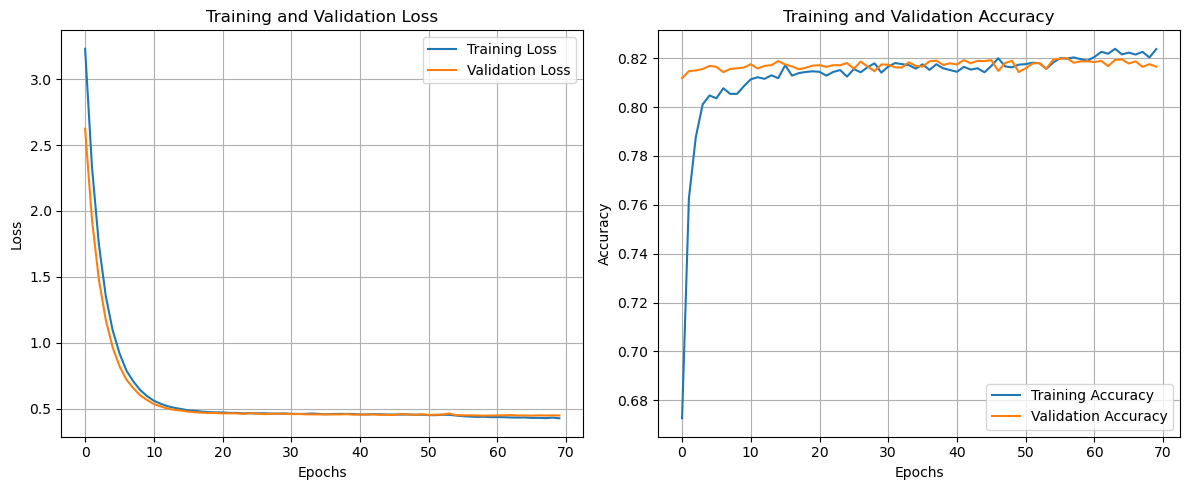

Final Training Loss: 0.4262
Final Validation Loss: 0.4474
Final Training Accuracy: 0.8237
Final Validation Accuracy: 0.8166


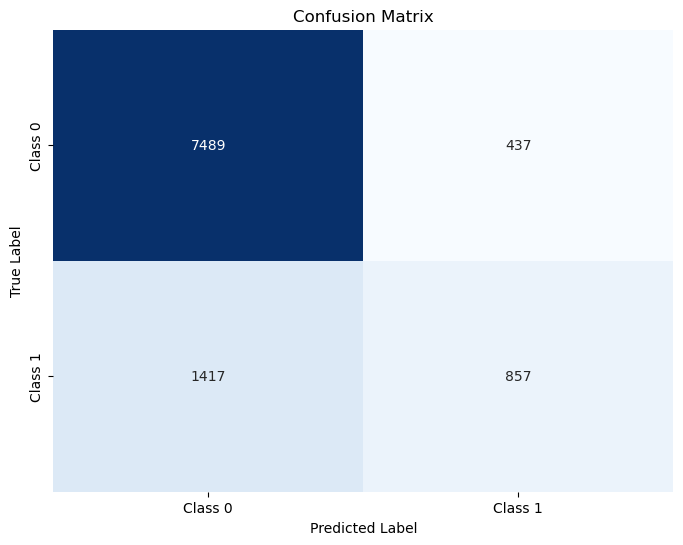

In [56]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt  # Matplotlib for plotting
import seaborn as sns  # Seaborn for enhanced visualization
from sklearn.metrics import confusion_matrix  # Function to compute confusion matrix
import numpy as np  # NumPy for numerical operations

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over epochs.

    Parameters:
    history (keras.callbacks.History): The history object returned from model.fit(),
                                        containing loss and accuracy metrics.
    """
    plt.figure(figsize=(12, 5))  # Set the figure size for the plots

    # Plot training and validation loss
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
    plt.title('Training and Validation Loss')  # Set title for the loss plot
    plt.xlabel('Epochs')  # Set x-axis label
    plt.ylabel('Loss')  # Set y-axis label
    plt.legend()  # Display legend
    plt.grid()  # Show grid for better readability

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
    plt.title('Training and Validation Accuracy')  # Set title for the accuracy plot
    plt.xlabel('Epochs')  # Set x-axis label
    plt.ylabel('Accuracy')  # Set y-axis label
    plt.legend()  # Display legend
    plt.grid()  # Show grid for better readability

    plt.tight_layout()  # Adjust subplot parameters for a cleaner layout
    plt.show()  # Display the plots

# Call the function to plot the training history
plot_training_history(history)

# Extract and print final metrics from the training history
final_train_loss = history.history['loss'][-1]  # Final training loss
final_val_loss = history.history['val_loss'][-1]  # Final validation loss
final_train_accuracy = history.history['accuracy'][-1]  # Final training accuracy
final_val_accuracy = history.history['val_accuracy'][-1]  # Final validation accuracy

# Print the final metrics
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Generate predictions on the validation set
y_pred_prob = model.predict(X_val_scaled, verbose=0)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix for predicted vs. true labels
cm = confusion_matrix(y_val, y_pred)  # Generate confusion matrix

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))  # Set the figure size for the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])  # Customize labels
plt.title('Confusion Matrix')  # Set title for the confusion matrix plot
plt.xlabel('Predicted Label')  # Set x-axis label
plt.ylabel('True Label')  # Set y-axis label
plt.show()  # Display the confusion matrix plot

## Validate the Model and Comment the Results

1. **Predictions**: probability predictions were generated for the validation set using the trained model. Probabilities were thresholded at `0.5`, classifying outcomes into “Default” (1) or “No Default” (0).

2. **Performance Metrics**: several key metrics were used to evaluate the model:
   - **Precision**: the proportion of correctly predicted defaults among all predicted defaults. High precision indicates fewer false positives.
   - **Recall**: the model's ability to identify actual defaults. High recall means fewer false negatives.
   - **F1-Score**: the harmonic mean of precision and recall, useful for balancing these metrics in imbalanced datasets.
   - **ROC AUC Score**: this measures the model’s ability to discriminate between classes across all thresholds. A higher AUC signifies better performance.

#### Results Interpretation

The classification report results shown below refer to the most accurate model that was built using the neural network. In other words, they refer to the model with `0.8316%` accuracy. Due to the non-determinism of the training process, every time the network is retrained, the values ​​will change. You can find the table with the updated results under the code cell

```
              precision    recall  f1-score   support

  No Default       0.84      0.94      0.89      7926
     Default       0.66      0.38      0.48      2274

    accuracy                           0.82     10200
   macro avg       0.75      0.66      0.69     10200
weighted avg       0.80      0.82      0.80     10200
```

- **Precision for "No Default"**: `0.84`, meaning 84% of predictions for non-defaulting _(customers who pay on time)_ clients were correct.
- **Recall for "No Default"**: `0.94`, indicating the model correctly identifies 94% of actual non-defaulters .
- **Precision for "Default"**: `0.66`, suggesting correct predictions for defaulters _(customers who do not pay)_ 66% of the time.
- **Recall for "Default"**: `0.38`, revealing that only 38% of actual defaulters were identified, leading to many false negatives.
- **F1-Score for "Default"**: `0.48`, reflecting an imbalance in precision and recall for defaulters.
- **Accuracy**: overall accuracy is `82%`, indicating reasonable performance but potentially masking issues with class balance.
- **ROC AUC Score**: at `0.7775`, this indicates a good ability to differentiate between classes.

#### Generalization Capability

The evaluation results suggest the model is experiencing a slight **underfitting** for the default class. While it performs well in predicting non-defaulting clients, it inadequately captures defaulters, as evidenced by the low recall metric. In other words, despite overall accuracy, the model’s struggle to identify defaulting clients. This leaves room for improvement. Potential strategies may include data augmentation, by enhancing the representation of the defaulting class in the training data. During the training process, I also tried to adjust the loss function with class weights that took into account the imbalance of the dataset, but this approach did not give the expected results. Therefore, I believe that the best way to solve the problem is to expose the training algorithm to more data. With only about **22%** of clients defaulting, the dataset’s imbalance therefore limits the model's ability to learn the default class's characteristics. Therefore, metrics like F1-Score and ROC AUC are very important to consider, as accuracy alone may be misleading.

In [57]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Predict the probabilities for the validation set
y_val_pred_prob = model.predict(X_val_scaled)

# Convert predicted probabilities to binary predictions using a threshold of 0.5
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Create a detailed classification report including precision, recall, and F1-score
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Calculate the ROC AUC score using the predicted probabilities
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.94      0.89      7926
     Default       0.66      0.38      0.48      2274

    accuracy                           0.82     10200
   macro avg       0.75      0.66      0.69     10200
weighted avg       0.80      0.82      0.80     10200

ROC AUC Score: 0.7775


## Make Predictions _(on the provided test set)_

Based on the training and validation results, it is possible to outline our expectations for the model's performance on the blind external test set.

#### Anticipated Performance

1. **Generalization Capability**: with a validation accuracy of around 80-83% and a ROC AUC score of 0.7775, the model is expected to perform well on the test set. These metrics suggest the model has identified significant patterns, although some underfitting, particularly in default class predictions, may impact test performance. In other words, an accuracy between 80%-83% on the test set in expected. 

2. **Class Imbalance Impact**: if the class distribution of the external test set mirrors that of the validation set, it could limit the model's ability to accurately predict defaults. Given the validation set's imbalance _(approximately 22% defaulting clients)_, similar results in precision and recall for the default class may occur.

3. **Potential Overfitting Risk**: despite implementing strategies like dropout and early stopping to reduce overfitting, there remains a risk that the model may struggle with unseen data. If the test set exhibits different characteristics or distributions, performance metrics—especially recall for the default class—could decline. I also expect a rather low F1-Score, around 40-50%, as the analysis conducted does not indicate either perfect precision or perfect recall.

4. While the model is likely to perform reasonably well on the blind external test set based on validation results, caution is needed regarding its generalization, particularly for the default class. If the test data aligns with the training distribution, results may reflect validation performance. However, any variations could lead to different outcomes, particularly in identifying defaulting customers. 

In [64]:
import pandas as pd  

# Load the test dataset from a CSV file
test_df = pd.read_csv('test.csv')

# Drop the 'ID' column if it exists, as it is not needed for predictions
if 'ID' in test_df.columns:
    test_df = test_df.drop(columns=['ID'])

# Copy the test dataset to preserve the original data structure
X_test = test_df.copy()

# Ensure that the number of features in the test set matches the expected number of features
if X_test.shape[1] == scaler.n_features_in_:
    # Standardize the test set using the same scaler fitted on the training data
    X_test_scaled = scaler.transform(X_test)
else:
    # Raise an error if the number of columns does not match the training data
    raise ValueError("Unable to standardize data: The number of columns does not match.")

# Predict the probabilities for the test set using the trained model
test_predictions_prob = model.predict(X_test_scaled)

# Convert predicted probabilities to binary class predictions using a threshold of 0.5
test_predictions = (test_predictions_prob > 0.5).astype(int)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).

In [65]:
# Save the predictions to a CSV file without including the header or index
pd.DataFrame(test_predictions, columns=['Predicted']).to_csv('test_predictions.csv', index=False, header=False)

In [60]:
from sklearn.metrics import accuracy_score, f1_score

true_labels_df = pd.read_csv('test_with_labels_real.csv', header=None)  
true_labels = true_labels_df[0].values 

predictions_df = pd.read_csv('test_predictions.csv', header=None)
predictions = predictions_df[0].values 

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8269
F1 Score: 0.4831
